### Initialization

In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,5
sb.set_style(style='darkgrid')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Producing user-genre matrix, that indicates how much each user likes a genre.

In [17]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
m_g_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation'
           , 'Children', 'Comedy','Crime', 'Documentary', 'Drama', 'Fantasy'
           , 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


data_set_path_users = "InputData/ml-100k/u.user"
data_set_path_ratings = "InputData/ml-100k/u.data"
data_set_path_movies = "InputData/ml-100k/u.item"
users = pd.read_csv(data_set_path_users,sep='|',names = u_cols)
ratings = pd.read_csv(data_set_path_ratings,sep='\t', names = r_cols).drop('timestamp',axis=1)
# ratings = np.array(pd.read_csv('InputData/R_SAD_4Clusters.csv').loc[:,'0':'1679'],dtype='float')
movies = pd.read_csv(data_set_path_movies, sep='|', names = m_cols, usecols=range(5))
movies_genre_df = pd.read_csv(data_set_path_movies, sep='|', names = m_g_cols).drop(['title', 'release_date', 'video_release_date', 'imdb_url'],axis=1)

### Users Demographic

In [10]:
# Load the user demographic data
user_data = pd.read_csv(data_set_path_users, sep='|', names=['user_id', 'age', 'sex', 'occupation', 'zip_code'], engine='python')

# Encode gender: 0 for male (M), 1 for female (F)
user_data['gender_encoded'] = user_data['sex'].apply(lambda x: 0 if x == 'M' else 1)
user_data.head(2)

,user_id,age,sex,occupation,zip_code,gender_encoded
0,1,24,M,technician,85711,0
1,2,53,F,other,94043,1


In [60]:
user_data = pd.DataFrame()

### DataSource Preparation

### Emplifying ratings by genres
Depicting the interest of each user for each genre

In [18]:
# cleaning the unknown items(movie) from our data - when we have the features of the items we can wok on it
# wherein our focosed feature is the genre of the movie so we find the movies with unknow genre and remove it from our dfs
movie_ids_to_be_removed = list(movies_genre_df[movies_genre_df['unknown'] == 1]['movie_id'])
for ids in movie_ids_to_be_removed:
    ratings.drop((ratings[ratings['movie_id'] == ids]).index, inplace=True)
    movies.drop((movies[movies['movie_id'] == ids]).index, inplace=True)
    movies_genre_df.drop((movies_genre_df[movies_genre_df['movie_id'] == ids]).index, inplace=True)  
# To Test run the code below
ratings.iloc[ratings[ratings['movie_id'] == ids].index]

,user_id,movie_id,rating


In [19]:
# G : Movie-Genre Matrix
# R : User-Movie Matrix
# UG: User-Genre Matrix
G = np.array(movies_genre_df.drop(['movie_id','unknown'],axis=1))
# R = np.array(pd.read_csv('InputData/R.csv').loc[:,'1':'1682'],dtype='float')
R = np.array(pd.read_csv('InputData/R_SAD_4Clusters.csv').loc[:,'0':'1679'],dtype='float')
UG = np.dot(R,G)
UG.shape

(784, 18)

In [22]:
G.shape, R.shape

((1680, 18), (784, 1680))

In [23]:
# Selecting features for clustering
X = np.hstack((UG,np.array(user_data[['age', 'gender_encoded']])))
X.shape

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 784 and the array at index 1 has size 943

### Normalize the features

In [24]:
# Initialize the scaler
scaler = MinMaxScaler()
#scaler = StandardScaler()   # standard normally distributed data (e.g., Gaussian with 0 mean and unit variance)

X_scaled = scaler.fit_transform(UG)
# pd.DataFrame(X_scaled).to_csv('X_scaled_minmax.csv')
X_scaled

array([[0.29868421, 0.31843575, 0.05882353, ..., 0.22075783, 0.22649573,
        0.32394366],
       [0.03552632, 0.00558659, 0.03361345, ..., 0.0708402 , 0.05982906,
        0.        ],
       [0.675     , 0.72067039, 0.67226891, ..., 0.51565074, 0.41452991,
        0.38028169],
       ...,
       [0.05921053, 0.06145251, 0.01680672, ..., 0.08896211, 0.12820513,
        0.04225352],
       [0.05394737, 0.03072626, 0.        , ..., 0.08566722, 0.05555556,
        0.        ],
       [0.08289474, 0.13687151, 0.        , ..., 0.16144975, 0.18803419,
        0.        ]])

e:\Users\Milad\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


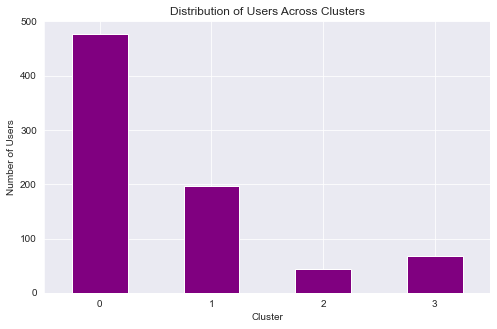

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
AccountType1,43.320755,20.872117,4.194969,8.259958,44.249476,16.660377,1.287212,77.452830,1.394130,3.392034,7.821803,5.144654,12.287212,36.538784,21.557652,43.454927,18.842767,1.763103
AccountType2,153.535714,85.443878,23.744898,42.020408,172.132653,47.295918,4.285714,245.448980,7.673469,10.892857,26.831633,32.168367,29.219388,119.739796,81.107143,123.423469,61.923469,11.602041
AccountType3,441.604651,241.209302,61.511628,124.697674,541.651163,141.744186,16.813953,727.581395,25.534884,37.953488,110.139535,94.209302,89.139535,343.604651,219.837209,375.581395,162.209302,40.093023
AccountType4,283.970588,163.367647,52.852941,96.250000,339.941176,87.441176,8.926471,452.485294,15.882353,20.750000,55.426471,68.161765,53.838235,217.779412,142.573529,230.588235,114.132353,27.352941


In [74]:
# Apply K-Means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
user_data['cluster'] = kmeans.fit_predict(X_scaled)

# Check the distribution of users across the clusters
cluster_distribution = user_data['cluster'].value_counts().sort_index()

# Visualize the distribution of users across clusters
plt.figure(figsize=(8, 5))
cluster_distribution.plot(kind='bar', color='purple')
plt.title('Distribution of Users Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.show()

# Let's also explore the centroids to understand the clusters better
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), index=['AccountType1', 'AccountType2', 'AccountType3', 'AccountType4'], columns=['Action', 'Adventure', 'Animation'
           , 'Children', 'Comedy','Crime', 'Documentary', 'Drama', 'Fantasy'
           , 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
# centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_))
centroids

In [75]:
user_data['cluster'].value_counts()

0    477
1    196
3     68
2     43
Name: cluster, dtype: int64

In [76]:
# user_data.reset_index(inplace=True)
user_data.rename(columns={'index':'account index'},inplace=True)

In [77]:
user_data

,account index,cluster
0,0,1
1,1,0
2,2,2
3,3,0
4,4,0
...,...,...
779,779,2
780,780,3
781,781,0
782,782,0


In [78]:
user_data[user_data['cluster'] == 3]

,account index,cluster
30,30,3
33,33,3
39,39,3
49,49,3
65,65,3
...,...,...
739,739,3
745,745,3
749,749,3
770,770,3


In [79]:
account_indices_of_Type =[]
for t in range(kmeans.n_clusters):
    account_indices_of_Type.append(list(user_data[user_data['cluster'] == t]['account index']))

In [80]:
%store account_indices_of_Type

Stored 'account_indices_of_Type' (list)


In [81]:
W_clustered = centroids.transpose()
W_clustered

,AccountType1,AccountType2,AccountType3,AccountType4
Action,43.320755,153.535714,441.604651,283.970588
Adventure,20.872117,85.443878,241.209302,163.367647
Animation,4.194969,23.744898,61.511628,52.852941
Children,8.259958,42.020408,124.697674,96.250000
Comedy,44.249476,172.132653,541.651163,339.941176
Crime,16.660377,47.295918,141.744186,87.441176
Documentary,1.287212,4.285714,16.813953,8.926471
Drama,77.452830,245.448980,727.581395,452.485294
Fantasy,1.394130,7.673469,25.534884,15.882353
Film-Noir,3.392034,10.892857,37.953488,20.750000


In [84]:
from sklearn.preprocessing import normalize

# Normalize the matrix so that each row has a unit sum
W_clustered_normal = normalize(W_clustered, axis=1, norm='l1')

pd.DataFrame(W_clustered_normal).to_csv('W_accounts_clustered_normal.csv')

In [83]:
W_clustered_normal

array([[0.04696364, 0.1664467 , 0.47873967, 0.30784999],
       [0.04085419, 0.16724419, 0.47213277, 0.31976885],
       [0.02947883, 0.16685986, 0.43225376, 0.37140755],
       [0.03045392, 0.15492649, 0.45975215, 0.35486744],
       [0.04030101, 0.15677291, 0.49331854, 0.30960754],
       [0.05683388, 0.16134151, 0.48353478, 0.29828983],
       [0.04110744, 0.1368654 , 0.53695799, 0.28506917],
       [0.05153324, 0.16330946, 0.48409624, 0.30106106],
       [0.02761483, 0.15199553, 0.50579314, 0.3145965 ],
       [0.04647361, 0.14924098, 0.51999358, 0.28429183],
       [0.03906615, 0.13401113, 0.55009411, 0.27682862],
       [0.02576397, 0.1610963 , 0.47179173, 0.341348  ],
       [0.066603  , 0.15838408, 0.48318204, 0.29183088],
       [0.05091359, 0.16684691, 0.47878297, 0.30345653],
       [0.04635301, 0.17439563, 0.47269141, 0.30655994],
       [0.05621245, 0.15965822, 0.48584484, 0.29828449],
       [0.05276491, 0.17340269, 0.45423052, 0.31960188],
       [0.02181758, 0.14356988,